In [1]:
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
import scipy.io as sio
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend, Parallel, delayed


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
data_dir = '/home/ubuntu/enigma/'
df =  pd.read_csv(data_dir + 'Behaviour_Information_ALL_April1_2022.csv', header=0)

In [3]:
df =  pd.read_csv(data_dir + 'Behaviour_Information_ALL_April1_2022.csv', header=0)
idx=np.isnan(df['NORMED_MOTOR'])

df=df[~idx]

site=df['SITE']

chronicity=df['CHRONICITY']
df_chronic=df[df['CHRONICITY']==180]
df_chronic=df_chronic.reset_index(drop=True)
ids=df_chronic['BIDS_ID']
ses=df_chronic['SES']
ids.to_csv(data_dir + '/chronic_ids.csv')

# Load SC regional (chronic)

# sub-r029s005 no MRI?
# sub-r052s034 no MRI?

nROIs=268
sc= np.zeros([len(ids),268])

for i in range(len(ids)):
    if i==293:
        continue
    if i==519:
        continue
        
    filename =  data_dir + "shen268_chaco/%s_ses-1_space-MNI152_desc-T1-lesion_mask_MNI_1mm_nemo_output_sdstream_chacovol_res2mm_smooth6mm_mean.nii.gz.txt" % (ids[i])
    
    sc_tmp = np.genfromtxt(filename, delimiter=',')
    sc[i,:] = sc_tmp
    
sc = np.delete(sc,(293), axis=0)   
sc = np.delete(sc,(519), axis=0)   

fuglmeyer=df_chronic['NORMED_MOTOR']

fuglmeyer.pop(293)
fuglmeyer.pop(519)


0.378787879

In [4]:
def feature_select_correlation(x_train, x_test, y, a):
    """Return values for the top a features of x based on abs. value Spearman correlation with y.
         Inputs:
             x_train = input matrix for training subjects
             x_test = input matrix for test subjects
             y = variable/s predicted 
             a = number of features to retain
        
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features
            ind = indices of top a features """
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
        
        
    # Feature selection: use only the top n features based on correlation of training features with y
    correl = abs(np_pearson_cor(x_train, y))
    ind = np.argpartition(correl, -a, 0)[-a:] # select top a features

    # return training/test data with only top features
    x_train_featselect=np.squeeze(x_train[:,ind],2)
    
    x_test_featselect=np.squeeze(x_test[:,ind],2)

    return x_train_featselect,x_test_featselect, ind


def gcv_ridge(hyperparam, x, y, k, featsel='None', a=10):
    """Perform gridsearch using k-fold cross-validation on a single hyperparameter 
    in ridge regression, and return mean R^2 across inner folds.
    
    Inputs: 
        hyperparam = list of hyperparameter values to train & test on validation est
        x = N x p input matrix
        y = 1 x p variable to predict
        k = k value in k-fold cross validation 
        featsel = type string, feature selection method, default="None"
            'None' - no feature selection; use all variables for prediction
            'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
            'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
        a = number of features to select using one of the above methods, default=10 
    
    Returns:
        expl_var = the mean R^2 (coefficient of determination) across inner loop folds for the given hyperparameter
    """
    
    # make sure k is reasonable 
    if x.shape[0]/k <= 2:
        raise Exception('R^2 is not well-defined with less than 2 subjects.')   
    
    # set alpha in ridge regression
    alpha = hyperparam
    # Initialize lists with final results
    y_pred_total = []
    y_valid_total = []
    R2 = []
    comp = []
    correl=[]
    explvar=[]
    # Split data into test and train: random state fixed for reproducibility
    kf = KFold(n_splits=k,shuffle=True,random_state=43)
    
    # K-fold cross-validation 
    for train_index, valid_index in kf.split(x):
        x_train, x_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        #x_train, x_valid = scale_data(x_train, x_valid)
        
        if featsel=='correlation':
            x_train, x_valid, ind = feature_select_correlation(x_train, x_valid, y_train, a)
            comp.append(ind)
            
        elif featsel=='PCA':
            x_train, x_valid, components = feature_select_PCA(x_train, x_valid, a)
            comp.append(components)
        
        # Fit ridge regression with (x_train_scaled, y_train), and predict x_train_scaled
        regr = linear_model.Ridge(alpha=alpha, normalize=True, max_iter=1000000, random_state=42)
        y_pred = regr.fit(x_train, y_train).predict(x_valid)

        R2.append(r2_score(y_valid, y_pred))
        correlation=np_pearson_cor(y_pred, y_valid)[0]
        correl.append(correlation)
        explvar.append(explained_variance_score(y_valid, y_pred))
        
        # Append y_pred and y_valid values of this k-fold step to list with all values
        y_pred_total.append(y_pred)
        y_valid_total.append(y_valid)
 
    # note: don't use r2_score for ridge regression bc it does not account for bias error
    r2=np.mean(R2)
    
    cor=np.mean(correl)
    
    # use explained_variance_score instead:
    expl_var=np.mean(explvar)
    
    return expl_var


In [5]:

def parallel_featsearch(alpha, X, Y, k, featselect, feat):
    ''' Grid search in parallel.

    Returns:
        expl_var - explained variance for given combination of alpha/feat/featselect'''
    
    expl_var=gcv_ridge(alpha, X, Y, k, featselect, feat)
    return expl_var

In [6]:

# Inner loop - grid search
def gridsearch_cv(k, x, y, featselect, alphas, feats):
    ''' Performs grid search using fixed predefined hyperparameter ranges and returns the best alpha and # of features for 
        a given training/validation sample. 
        
        Input:
            x = N x p input matrix
            y = 1 x p variable to predict
            k = k value in k-fold cross validation 
            featsel = type string, feature selection method, default="None"
                'None' - no feature selection; use all variables for prediction
                'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
                'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
            alphas - range of alpha parameters to search 
            feats - range of # features to search
        
        Returns:
            bestalpha - optimal alpha based on grid search
            bestfeats - optimal number of features based on grid search
            bestr2 - mean R^2 across folds obtained for the optimal combination of hyperparameters
            gcv_values - R^2 across all combinations of hyperparametrs.'''
    
    print(str(k)+"-fold cross-validation results in "+str((x.shape[0]/k)*(k-1))+ " subjects in the training set, and "+ str(x.shape[0]/k) + " subjects in the validation set")

    # initialize array to store r2
    gcv_values=np.empty(shape=(len(alphas),len(feats)),dtype='float')

    # iterate through alphas
    for alpha in alphas:
        row, = np.where(alphas==alpha)
        
        # run feature selection (# of components) in parallel
        gcv=Parallel(n_jobs=-1,verbose=0)(delayed(parallel_featsearch)(alpha,x, y, k, featselect, feat) for feat in feats)
        gcv=np.array(gcv)
        gcv_values[row]=gcv
            
        row=np.argmax(np.max(gcv_values, axis=1))
        col=np.argmax(np.max(gcv_values, axis=0))

    bestalpha=alphas[row]
    bestfeats=feats[col]
    bestr2=np.max(gcv_values)

    return bestalpha, bestfeats, bestr2, gcv_values


In [10]:

def np_pearson_cor(x, y):
    '''Fast array-based pearson correlation that is more efficient. 
    FROM: https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)


5-fold cross-validation results in 369.6 subjects in the training set, and 92.4 subjects in the validation set
Best combination: 
 alpha =  0.32903445623126676 
 Features =  103 
 R^2 =  0.229
0.22915869915028497
[[0.48025232]]


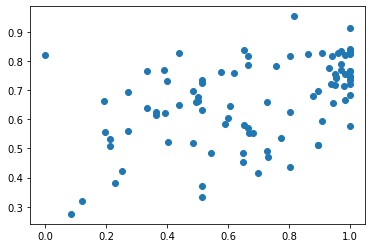

In [184]:
# -------------------- MODEL OPTIMIZATION --------------------
# range of alphas
n_alphas=30
alpha_start=-2
alpha_end=2
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10,dtype=None)
p=0

#number of features (# pricipal components or variables to retain)
feat_start=50
feat_end=268

n_feats=feat_end-feat_start+1
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

#set the proportion of data you want in your training set
train_size = .8

#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5
#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=np.array(sc)

#set y to be the measure you want to predict
Y = np.array(fuglmeyer)
Y=np.reshape(Y, (578,1))

featselect = 'correlation'

# set aside data for hold-out final testing: 
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=134)

bestalpha, bestfeats, bestr2, gcv_values_r2= gridsearch_cv(k, x, y, featselect, alphas, feats)

row=np.argmax(np.max(gcv_values_r2, axis=1))
col=np.argmax(np.max(gcv_values_r2, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values_r2), 3)))

# initialize Ridge regression with alpha selected from hyperparameter search
regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size, shuffle=True, random_state=121)

if featselect=='correlation':
    x_train_featselect,x_test_featureselect,ind = feature_select_correlation(x_train,x_test, y_train, bestfeats)

# initialize Ridge regression with alpha selected from hyperparameter search
regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)


# fit model 
y_pred = regr.fit(x_train_featselect, y_train).predict(x_test_featureselect)

expl=explained_variance_score(y_test, y_pred)

print(expl)

plt.scatter(y_test, y_pred)


<ipython-input-164-c606a2cabb90>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


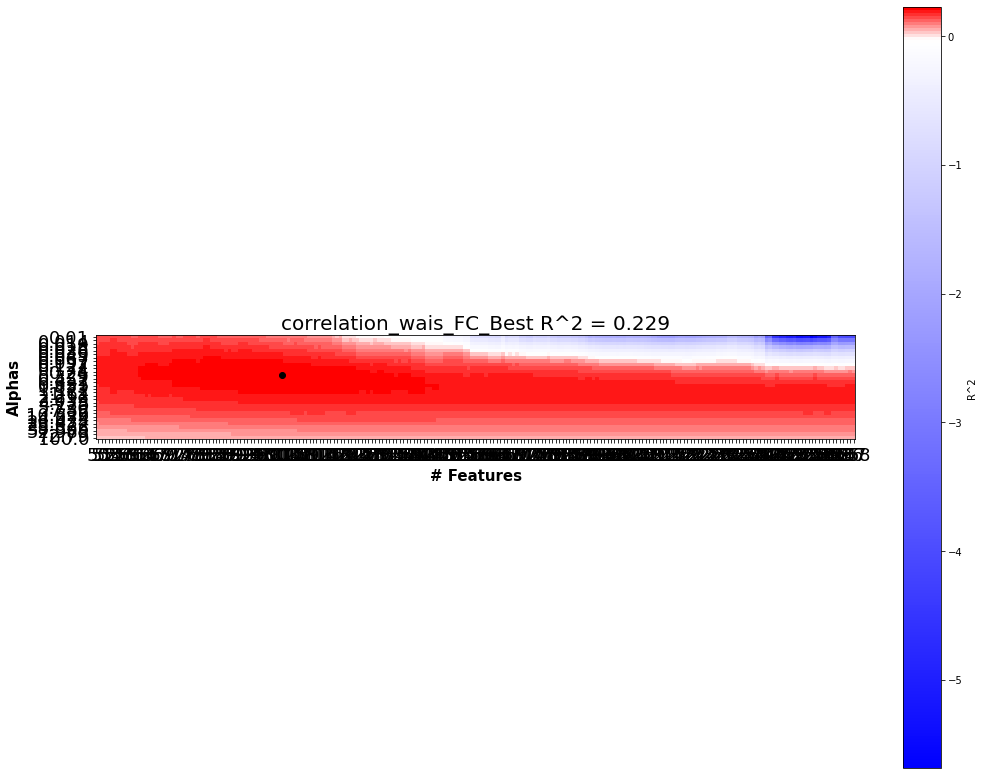

In [185]:
plot_figure(gcv_values_r2,'correlation_wais_FC',0.96)

In [7]:
def plot_figure(gcv_values, string, midpoint):
    '''Plots the R^2 value obtained across all grid-search pairs (# features and regularization values.)
    
    Inputs:
        gcv_values - matrix to plot
        string - title
        midpoint - point at which blue turns to red.'''
    
    plt.figure(figsize=(17,14))
    shifted_cmap = shiftedColorMap(plt.get_cmap('bwr'), midpoint=midpoint, name='shifted')

    plt.imshow(gcv_values, cmap=shifted_cmap, interpolation='nearest')

    plt.xlabel('# Features', fontsize=15, fontweight='bold')
    plt.ylabel('Alphas', fontsize=15, fontweight='bold')

    row=np.argmax(np.max(gcv_values, axis=0))
    col=np.argmax(np.max(gcv_values, axis=1))

    ax = plt.axes()

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    xticks= np.linspace(feat_start, feat_end,n_feats, dtype=int)
    yticks= np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    plt.xticks(np.arange(len(feats)), fontsize=18)
    plt.yticks(np.arange(len(alphas)), fontsize=18)

    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.round(yticks,3))

    #ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{xticks: .2f}'))
    cbar = plt.colorbar()
    cbar.set_label('R^2')
    plt.title(string + '_Best R^2 = ' + str(np.round(np.max(gcv_values), 3)), fontsize=20)

    plt.scatter(row,col,color='k')
    #plt.savefig(results_dir+string+ '.png')
    plt.show()

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    FROM: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [ ]:
# predictions for SC-  PCA and correlation
results_dir='/home/ubuntu/enigma/results/correlation_sc_regional/'
import datetime
import pickle 

# feature selection type
f=['correlation']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #X=np.concatenate([sc, fc], axis=1)
    X=sc

    #set y to be the measure you want to predict
    #Y = np.log(np.array(tmt))

    Y=np.array(fuglmeyer)
    Y=np.reshape(Y, (578,1))
    
    # range of alphas
    n_alphas=30
    alpha_start=-2
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=70
    feat_end=268
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    chronic_allexpl_var=[]
    chronic_correlationr2_all=[]
    #joblib-based parallelism to increase speed,
    ytestc=[]
    ypredc=[]
    for p in range(13, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        chronic_explvar=[]
        chronic_correlationr2=[]

        cor=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()
            
            
            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)
                
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))
            
    
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
    
        print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()
        
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
        pickle.dump(correlations, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
     
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
        pickle.dump(impt, output)
        output.close()   
        
        


Permutation: 13
5-fold cross-validation results in 369.6 subjects in the training set, and 92.4 subjects in the validation set
time to run loop: 0:00:17.765438
Explained var: 0.22668955878036878
correlation: [[0.47614325]]
5-fold cross-validation results in 369.6 subjects in the training set, and 92.4 subjects in the validation set
time to run loop: 0:00:16.906707
Explained var: 0.2986791568620958
correlation: [[0.54658049]]
5-fold cross-validation results in 369.6 subjects in the training set, and 92.4 subjects in the validation set
time to run loop: 0:00:16.802468
Explained var: 0.300131439765876
correlation: [[0.55748797]]
5-fold cross-validation results in 370.4 subjects in the training set, and 92.6 subjects in the validation set
time to run loop: 0:00:16.819387
Explained var: 0.07617133752805683
correlation: [[0.30500981]]
5-fold cross-validation results in 370.4 subjects in the training set, and 92.6 subjects in the validation set
time to run loop: 0:00:16.840747
Explained var: 

time to run loop: 0:00:16.881098
Explained var: 0.2357279711680934
correlation: [[0.48675531]]
5-fold cross-validation results in 370.4 subjects in the training set, and 92.6 subjects in the validation set
time to run loop: 0:00:16.818528
Explained var: 0.3071232248566038
correlation: [[0.55423273]]
5-fold cross-validation results in 370.4 subjects in the training set, and 92.6 subjects in the validation set
time to run loop: 0:00:16.876447
Explained var: 0.2392508336416268
correlation: [[0.4891699]]
---- Permutation avg. explained variance: 0.24477649964913617----
Permutation: 21
5-fold cross-validation results in 369.6 subjects in the training set, and 92.4 subjects in the validation set
time to run loop: 0:00:16.605249
Explained var: 0.22122535433999724
correlation: [[0.47347302]]
5-fold cross-validation results in 369.6 subjects in the training set, and 92.4 subjects in the validation set
time to run loop: 0:00:16.839940
Explained var: 0.1709723044513609
correlation: [[0.41357959]]

In [111]:
# Haufe transformation of feature weights
k=5
results_dir='/home/ubuntu/enigma/results/correlation_sc_regional/'
Y = np.array(fuglmeyer)

perm=0
fullactivations=[] 
#iterate through permutations
for p in range(0,100):
    k=5
    
    # load activation weights
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_varimpt.pkl', 'rb') as f:
        activ = pickle.load(f)
        
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    
    # Load features selected from permutation
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features.pkl', 'rb') as f:
        feats = pickle.load(f)
    
    c=0   
    activations=[]
    X=sc

    fullactivation=[]
    activationweight=[]
    for train, test in outer_cv.split(X):
        x_train=X[train]
        X=x_train
        X_sub=X[:,feats[c][:]]
        
        X_sub=np.reshape(X_sub, [len(train),feats[c].shape[0]])
        cov_x=np.cov(np.transpose(X_sub))
        
        print(X_sub.shape)
        if feats[c].shape[0]==1:
            cov_x=np.reshape(cov_x, [1,1])
        
    
        cov_y=np.cov(np.transpose(Y[train]))
    
        activationweight=activ[c]

        #print(activationweight.shape)
        weight=np.transpose(activationweight)

        print(cov_x.shape)
        print(weight.shape)
        print(cov_y.shape)
        activation=np.matmul(cov_x,weight)*(1/cov_y)
        activations.append(activation)
        #print(activation.shape)

        # get activation weights back to matrix form 86x86
        # get indices of weights not selected as features; set weight to 0    
        idx=np.ones(shape=(268,1), dtype='bool')
        idx[feats[c]]=False # set SC weights that are features to be 1
        idx=idx.flatten()
        zeroidx=np.arange(0, 268, dtype='int')
        zeroidx=zeroidx[idx]
        
        # fill spots with 0's (up to 3192)
        k=0
        activation_full = activation
        while k < zeroidx.shape[0]:
            activation_full=np.insert(activation_full, zeroidx[k],0)
            k=k+1
        
        #print("Full 3192: " + str(np.sum(activation_full>0)))
        # fill spots with 0's (up to 3655)
        X=sc
        zeros=sc==0
        zeros=np.sum(zeros,0) # number of zeros across subjects
        zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
        X=X[:,~zeros]
        
        zeroidx=np.arange(0, 268)
        zeroidx=zeroidx[zeros]

        # fill spots with 0's
        k=0
        a = activation_full
        while k < zeroidx.shape[0]:
            a=np.insert(a, zeroidx[k],0)
            k=k+1
        
        #print("Full 268: " + str(np.sum(a>0)))
        fullactivation.append(a)
        c=c+1
         
    fullactivations.append(fullactivation)

(462, 180)
(180, 180)
(180, 1)
()
(462, 134)
(134, 134)
(134, 1)
()
(462, 73)
(73, 73)
(73, 1)
()
(463, 85)
(85, 85)
(85, 1)
()
(463, 83)
(83, 83)
(83, 1)
()
(462, 89)
(89, 89)
(89, 1)
()
(462, 105)
(105, 105)
(105, 1)
()
(462, 127)
(127, 127)
(127, 1)
()
(463, 72)
(72, 72)
(72, 1)
()
(463, 264)
(264, 264)
(264, 1)
()
(462, 86)
(86, 86)
(86, 1)
()
(462, 101)
(101, 101)
(101, 1)
()
(462, 128)
(128, 128)
(128, 1)
()
(463, 104)
(104, 104)
(104, 1)
()
(463, 106)
(106, 106)
(106, 1)
()
(462, 94)
(94, 94)
(94, 1)
()
(462, 99)
(99, 99)
(99, 1)
()
(462, 96)
(96, 96)
(96, 1)
()
(463, 114)
(114, 114)
(114, 1)
()
(463, 87)
(87, 87)
(87, 1)
()
(462, 105)
(105, 105)
(105, 1)
()
(462, 70)
(70, 70)
(70, 1)
()
(462, 123)
(123, 123)
(123, 1)
()
(463, 123)
(123, 123)
(123, 1)
()
(463, 102)
(102, 102)
(102, 1)
()
(462, 95)
(95, 95)
(95, 1)
()
(462, 128)
(128, 128)
(128, 1)
()
(462, 75)
(75, 75)
(75, 1)
()
(463, 86)
(86, 86)
(86, 1)
()
(463, 86)
(86, 86)
(86, 1)
()
(462, 70)
(70, 70)
(70, 1)
()
(462, 91)


In [155]:
# SC average across stroke subjects
from nilearn import datasets
from nilearn import plotting

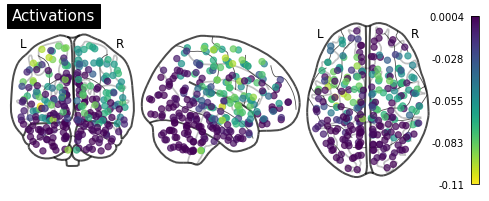

In [173]:
shen268_activations=np.empty((268,)) 

for p in range(0,100):
    act=fullactivations[p] # features 
    for x in range(0,5):
        shen268_activations=np.vstack((shen268_activations, np.transpose(act[x])))
        
shen268_region=np.mean(shen268_activations[1:],axis=0)

coordinates = plotting.find_parcellation_cut_coords('/home/ubuntu/enigma/shen_2mm_268_parcellation.nii')
plotting.plot_markers(shen268_region, coordinates,node_size=40,
                         title='Activations',colorbar=True)

np.savetxt(results_dir + 'avgHaufe_shen268_regionalSDC_correlation_chronic.txt', shen268_region, delimiter=',')
np.savetxt(results_dir + 'allHaufe_shen268_regionalSDC_correlation_chronic.txt', shen268_activations[1:, delimiter=',')


In [171]:
shen268_activations

array([[ 6.92989860e-310,  6.92989860e-310,  4.68297925e-310, ...,
        -5.68749510e-002, -6.32723847e-002,  0.00000000e+000],
       [ 0.00000000e+000, -1.41107865e-002,  0.00000000e+000, ...,
        -5.68749510e-002, -6.32723847e-002,  0.00000000e+000],
       [ 0.00000000e+000, -2.07707475e-002,  0.00000000e+000, ...,
        -7.83878577e-002,  0.00000000e+000,  0.00000000e+000],
       ...,
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
        -1.32597880e-001,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000, -3.75734457e-002,  0.00000000e+000, ...,
        -1.75240258e-001,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
        -1.34711878e-001,  0.00000000e+000,  0.00000000e+000]])